In [1]:
#importing python classes
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import matplotlib
from sklearn import svm
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pyswarms as ps
from SwarmPackagePy import testFunctions as tf
from sklearn import linear_model
from keras.layers import Conv2D, InputLayer, BatchNormalization

Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [28]:
pso_classifier = linear_model.LogisticRegression(max_iter=3000)

In [29]:
#load lex emotion to identify sub emotions from posts
emotion_lex = pd.read_csv("Dataset/NRC-emotion-lexicon.txt",names=["word", "emotion", "association"], sep='\t', keep_default_na=False)
print(emotion_lex.head())
emotion_lex = emotion_lex.values
print("Lex emotion loaded & its size: "+str(len(emotion_lex)))

    word       emotion  association
0  aback         anger            0
1  aback  anticipation            0
2  aback       disgust            0
3  aback          fear            0
4  aback           joy            0
Lex emotion loaded & its size: 141820


In [30]:
#module to get subemotion of given words
def getEmotion(query):
    sub_emotion = None
    for i in range(len(emotion_lex)):
        word = emotion_lex[i,0]
        emotion = emotion_lex[i,1]
        association = emotion_lex[i,2]
        if word == query and association == 1:
            sub_emotion = emotion
            break
    return sub_emotion #return sub emotion of given word

In [31]:
#module to Load dataset to get static BOS features
text = []
label = []
subject = []
dataset = pd.read_csv("Dataset/train.csv")
for i in range(len(dataset)):
    textData = dataset.get_value(i, 'Text')
    lbl = dataset.get_value(i, 'Labels')
    subject_id = dataset.get_value(i, 'ID')
    textData = textData.strip().lower()
    textData = textData[0:300]
    text.append(textData)
    label.append(lbl)
    subject.append(subject_id)
print("Total users post found in dataset: "+str(len(text)))

Total users post found in dataset: 152


In [32]:
#module to mask each word  from users POST
mask = []
users = []
user_label = []
BOS = []
if os.path.exists('model/bos.txt'):
    with open('model/bos.txt', 'rb') as file:
        BOS = pickle.load(file)
    file.close()
    mask = BOS[0]
    users = BOS[1]
    user_label = BOS[2]
else:
    for i in range(len(text)):
        textData = text[i].strip().lower()
        tokens = textData.split(" ")
        emotion = ''
        for token in tokens:
            sub_emotion = getEmotion(token.strip())
            if sub_emotion is not None:
                emotion += sub_emotion+" "
        if len(emotion.strip()) > 0:
            mask.append(emotion)
            users.append(subject[i])
            user_label.append(label[i])
    BOS = [mask,users,user_label]
    with open('model/bos.txt', 'wb') as file:
        pickle.dump(BOS, file)
    file.close()  
temp = np.asarray(mask)
print(temp)

['negative negative trust ' 'anticipation positive anticipation positive '
 'joy joy joy positive anger anticipation anger '
 'fear anticipation anticipation positive '
 'positive anticipation anticipation negative '
 'trust anticipation trust negative positive '
 'positive positive positive joy disgust anger '
 'anger anticipation anticipation joy fear negative ' 'positive '
 'disgust joy disgust disgust ' 'positive joy ' 'surprise trust fear '
 'positive positive negative ' 'negative ' 'positive joy anticipation '
 'positive positive positive joy anger '
 'anger anticipation anticipation anticipation positive anger positive '
 'disgust anger anticipation disgust positive negative '
 'fear anticipation '
 'fear anger anticipation positive positive positive fear '
 'disgust negative trust fear ' 'anger anticipation anger anticipation '
 'anger anger positive ' 'trust positive '
 'anticipation anticipation positive '
 'anticipation anticipation anticipation positive trust surprise '
 'f

TF-IDF Weight values
     anger  anticipation  disgust      fear       joy  negative  positive  \
0  0.00000      0.000000      0.0  0.000000  0.000000  0.869811  0.000000   
1  0.00000      0.717430      0.0  0.000000  0.000000  0.000000  0.696631   
2  0.46092      0.181194      0.0  0.000000  0.850745  0.000000  0.175941   
3  0.00000      0.723981      0.0  0.593551  0.000000  0.000000  0.351496   
4  0.00000      0.761952      0.0  0.000000  0.000000  0.531582  0.369931   

   sadness  surprise     trust  
0      0.0       0.0  0.493386  
1      0.0       0.0  0.000000  
2      0.0       0.0  0.000000  
3      0.0       0.0  0.000000  
4      0.0       0.0  0.000000  


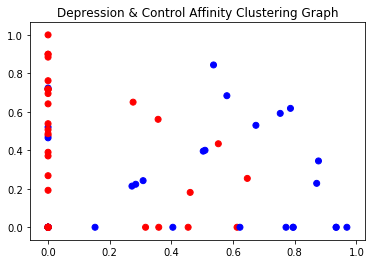

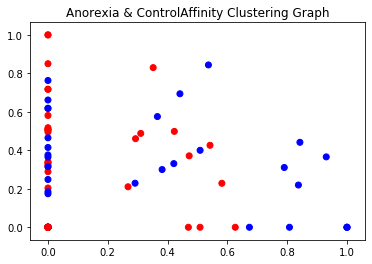

In [33]:
#module to convert mask features into TF-IDF weight and then perform afficnity clustering
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(mask).toarray()        
df = pd.DataFrame(tfidf, columns=tfidf_vectorizer.get_feature_names())
print("TF-IDF Weight values")
print(df.head())
df = df.values
X = df[:, 0:df.shape[1]]
Y = np.asarray(user_label)
clustering = AffinityPropagation().fit(X) #peffroming affinity alustering
centroid = clustering.cluster_centers_
predict = clustering.predict(X) #predicting control and depress user
sc = plt.scatter(X[0:70,0], X[0:70,1], c = predict[0:70], cmap = matplotlib.colors.ListedColormap(['blue','red']))
plt.title("Depression & Control Affinity Clustering Graph")
plt.show()
sc = plt.scatter(X[70:149,0], X[70:149,1], c = predict[70:149], cmap = matplotlib.colors.ListedColormap(['blue','red']),label=['Control','Anorexia'])
plt.title("Anorexia & ControlAffinity Clustering Graph")
plt.show()

In [34]:
#module to train SVM on MASK & TF-IDF features and then calculate F1 SCORE
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
svm_cls = svm.SVC() #training with SVM
svm_cls.fit(X_train, y_train)
svm_predict = svm_cls.predict(X_test) 
F1 = f1_score(y_test,svm_predict,average='macro') * 100
print("\nSVM F1-Score: "+str(F1))


SVM F1-Score: 47.36842105263158


In [35]:
Y_train = to_categorical(y_train)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1,1)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1],1,1)
classifier = Sequential() #Training with CNN
classifier.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (1, 1)))
classifier.add(Convolution2D(32, 1, 1, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (1, 1)))
classifier.add(Flatten())
classifier.add(Dense(output_dim = 256, activation = 'relu'))
classifier.add(Dense(output_dim = Y_train.shape[1], activation = 'softmax'))                             
print(classifier.summary())
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = classifier.fit(X_train, Y_train, batch_size=16, epochs=10, shuffle=True, verbose=2)
predict = classifier.predict(X_test) #perform prediction
predict = np.argmax(predict, axis=1)
testLabel = y_test
fscore = f1_score(testLabel,predict,average='macro') * 100    
fscore = hist.history['accuracy'][9]* 100 
print("\nCNN F1-Score: "+str(fscore)+"\n")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 10, 1, 32)         64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 1, 32)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 1, 32)         1056      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 1, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               82176     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                

In [36]:
def f_per_particle(m, alpha):
    global X
    global Y
    global pso_classifier
    total_features = X.shape[1]
    if np.count_nonzero(m) == 0:
        X_subset = X
    else:
        X_subset = X[:,m==1]
    pso_classifier.fit(X_subset, Y)
    P = (pso_classifier.predict(X_subset) == Y).mean()
    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

In [37]:
from keras.layers import MaxPool2D
global tfidf_vectorizer, X, Y
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 5, 'p':2}
dimensions = X.shape[1] # dimensions should be the number of features
optimizer = ps.discrete.BinaryPSO(n_particles=10, dimensions=dimensions, options=options) #CREATING PSO OBJECTS 
cost, pos = optimizer.optimize(f, iters=10)#OPTIMIZING FEATURES
print("\nFeatures found in dataset before applying PSO : "+str(X.shape[1])+"\n")
X_selected_features = X[:,pos==1]  # PSO WILL SELECT IMPORTANT FEATURES WHERE VALUE IS 1
print("Features found in dataset after applying PSO : "+str(X_selected_features.shape[1])+"\n")
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, Y, test_size=0.2)
svm_cls = svm.SVC() #training with SVM
svm_cls.fit(X_selected_features, Y)
svm_predict = svm_cls.predict(X_test) 
F1 = f1_score(y_test,svm_predict,average='macro') * 100
print("Extension PSO Optimized SVM F1-Score: "+str(F1)+"\n")
Y_train = to_categorical(y_train)
Y1 = to_categorical(Y)
XX = X_selected_features.reshape(X_selected_features.shape[0],X_selected_features.shape[1],1,1)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1,1)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1],1,1)
classifier1 = Sequential()
classifier1.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
classifier1.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
classifier1.add(MaxPool2D(pool_size=(1, 1), padding='same'))
classifier1.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
classifier1.add(MaxPool2D(pool_size=(1, 1), padding='same'))
classifier1.add(BatchNormalization())
classifier1.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
classifier1.add(MaxPool2D(pool_size=(1, 1), padding='valid'))
classifier1.add(BatchNormalization())
classifier1.add(Flatten())
classifier1.add(Dense(units=100, activation='relu'))
classifier1.add(Dense(units=100, activation='relu'))
classifier1.add(Dropout(0.25))
classifier1.add(Dense(units=Y1.shape[1], activation='softmax'))
classifier1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
hist = classifier1.fit(XX, Y1,  epochs=10, shuffle=True, verbose=2)
predict = classifier1.predict(X_test) #perform prediction
predict = np.argmax(predict, axis=1)
testLabel = y_test
fscore = f1_score(testLabel,predict,average='macro') * 100   
fscore = hist.history['accuracy'][9]* 100 
print("\nExtension PSO Optimized CNN F1-Score: "+str(fscore)+"\n\n")

2022-05-18 22:40:32,342 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 5, 'p': 2}
pyswarms.discrete.binary: 100%|████████████████████████████████████████████████████████████████████|10/10, best_cost=0.13
2022-05-18 22:40:33,072 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.13012080536912754, best pos: [1 1 1 1 1 0 1 1 1 1]



Features found in dataset before applying PSO : 10

Features found in dataset after applying PSO : 9

Extension PSO Optimized SVM F1-Score: 47.36842105263158

Epoch 1/10
 - 1s - loss: 0.6883 - accuracy: 0.6174
Epoch 2/10
 - 0s - loss: 0.4103 - accuracy: 0.8591
Epoch 3/10
 - 0s - loss: 0.3452 - accuracy: 0.8725
Epoch 4/10
 - 0s - loss: 0.3328 - accuracy: 0.8591
Epoch 5/10
 - 0s - loss: 0.3145 - accuracy: 0.8792
Epoch 6/10
 - 0s - loss: 0.2530 - accuracy: 0.8859
Epoch 7/10
 - 0s - loss: 0.2929 - accuracy: 0.8792
Epoch 8/10
 - 0s - loss: 0.2535 - accuracy: 0.9060
Epoch 9/10
 - 0s - loss: 0.2609 - accuracy: 0.8926
Epoch 10/10
 - 0s - loss: 0.2234 - accuracy: 0.9195

Extension PSO Optimized CNN F1-Score: 91.94630980491638




In [38]:
chunk_mask = []
chunk_users = []
chunk_user_label = []
dynamic_BOS = []
if os.path.exists('model/dynamic_bos.txt'):
    with open('model/dynamic_bos.txt', 'rb') as file:
        dynamic_BOS = pickle.load(file)
    file.close()
    chunk_mask = dynamic_BOS[0]
    chunk_users = dynamic_BOS[1]
    chunk_user_label = dynamic_BOS[2]
else:
    for i in range(len(chunk_text)):
        textData = chunk_text[i].strip().lower()
        tokens = textData.split(" ")
        emotion = ''
        for token in tokens:
            sub_emotion = getEmotion(token.strip())
            if sub_emotion is not None:
                emotion += sub_emotion+" "
        if len(emotion.strip()) > 0:
            chunk_mask.append(emotion)
            chunk_users.append(chunk_subject[i])
            chunk_user_label.append(chunk_label[i])
    dynamic_BOS = [chunk_mask,chunk_users,chunk_user_label]
    with open('model/dynamic_bos.txt', 'wb') as file:
         pickle.dump(dynamic_BOS, file)
    file.close()  

In [39]:
def getCount(mask_list, emotion):
    #'negative , anticipation, anger disgust trust 
    arr = mask_list.split(" ")
    count = 0
    for i in range(len(arr)):
        if arr[i] == emotion:
            count += 1
    return count   
    
    

In [40]:
#Comparison of the emotional signals between control and mental-disorder groups. X-axis represents the chunks (time span)
#and Y-axis represents
#the average value of the sub-emotion at each chunk.
chunk_users = np.asarray(chunk_users)
group,count = np.unique(chunk_users,return_counts=True)
groups = len(chunk_users)-40
group_index = 100 
start = 0
max_group = 0
control_anger_group = []
control_negative_group = []
control_trust_group = []
control_anti_group = []
control_disgust_group = []

depression_anger_group = []
depression_negative_group = []
depression_trust_group = []
depression_anti_group = []
depression_disgust_group = []

ano_anger_group = []
ano_negative_group = []
ano_trust_group = []
ano_anti_group = []
ano_disgust_group = []

while group_index < groups:
    control_anger  = 0
    control_trust = 0
    control_disgust = 0
    control_anticipation = 0
    control_negative = 0
    depression_anger  = 0
    depression_trust = 0
    depression_disgust = 0
    depression_anticipation = 0
    depression_negative = 0
    ano_anger  = 0
    ano_trust = 0
    ano_disgust = 0
    ano_anticipation = 0
    ano_negative = 0
    for i in range(start,group_index):
        for j in range(len(chunk_mask)):
            if max_group < 5:
                if chunk_users[j] == group[i] and chunk_user_label[j] == 0 or chunk_user_label[j] == 1:
                    control_anger  = control_anger + getCount(chunk_mask[j],"anger")/100
                    control_trust = control_trust + getCount(chunk_mask[j],"trust")/100
                    control_disgust = control_disgust + getCount(chunk_mask[j],"disgust")/100
                    control_anticipation = control_anticipation + getCount(chunk_mask[j],"anticipation")/100
                    control_negative = control_negative + getCount(chunk_mask[j],"negative")/100
                if chunk_users[j] == group[i] and chunk_user_label[j] == 0:
                    ano_anger  = ano_anger + getCount(chunk_mask[j],"anger")
                    ano_trust = ano_trust + getCount(chunk_mask[j],"trust")
                    ano_disgust = ano_disgust + getCount(chunk_mask[j],"disgust")
                    ano_anticipation = ano_anticipation + getCount(chunk_mask[j],"anticipation")
                    ano_negative = ano_negative + getCount(chunk_mask[j],"negative")    
                if chunk_users[j] == group[i] and chunk_user_label[j] == 1:
                    depression_anger  = depression_anger + getCount(chunk_mask[j],"anger")
                    depression_trust = depression_trust + getCount(chunk_mask[j],"trust")
                    depression_disgust = depression_disgust + getCount(chunk_mask[j],"disgust")
                    depression_anticipation = depression_anticipation + getCount(chunk_mask[j],"anticipation")
                    depression_negative = depression_negative + getCount(chunk_mask[j],"negative")    
    if max_group < 5:
        print("Control: "+str(control_anger)+" "+str(control_trust)+" "+str(control_disgust)+" "+str(control_anticipation)+" "+str(control_negative))
        print("Depression: "+str(depression_anger)+" "+str(depression_trust)+" "+str(depression_disgust)+" "+str(depression_anticipation)+" "+str(depression_negative))
        control_anger_group.append(control_anger/100)
        control_negative_group.append(control_negative/100)
        control_trust_group.append(control_trust/100)
        control_anti_group.append(control_anticipation/100)
        control_disgust_group.append(control_disgust/100)
        depression_anger_group.append(depression_anger/100)
        depression_negative_group.append(depression_negative)
        depression_trust_group.append(depression_trust/100)
        depression_anti_group.append(depression_anticipation/100)
        depression_disgust_group.append(depression_disgust/100)
        ano_anger_group.append(ano_anger/100)
        ano_negative_group.append(ano_negative/100)
        ano_trust_group.append(ano_trust/100)
        ano_anti_group.append(ano_anticipation/100)
        ano_disgust_group.append(ano_disgust/100)
    start = group_index - 28
    group_index = group_index + 10
    max_group += 1

Control: 110.93000000000727 32.49000000000128 31.40000000000109 207.34000000000103 78.57000000000266
Depression: 44 13 10 72 32
Control: 42.000000000000576 12.259999999999797 11.819999999999832 78.58000000000197 29.79000000000095
Depression: 15 8 5 35 10
Control: 42.02000000000057 12.269999999999797 11.809999999999834 78.59000000000196 29.77000000000095
Depression: 15 8 5 35 10
Control: 42.00000000000056 12.279999999999797 11.819999999999832 78.65000000000195 29.780000000000953
Depression: 8 1 1 8 3
Control: 41.95000000000056 12.219999999999798 11.809999999999834 78.56000000000195 29.770000000000948
Depression: 18 6 11 50 15


In [24]:
def graph(title,control,emotion):
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Chunk Time')
    plt.ylabel('Average Emotion Value')
    plt.plot(control, 'ro-', color = 'blue')
    plt.plot(emotion, 'ro-', color = 'red')
    plt.legend(['Control', 'Depression'], loc='upper left')
    plt.title(title)
    plt.show()       

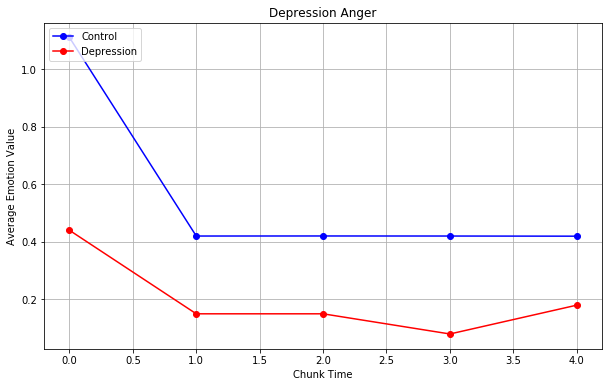

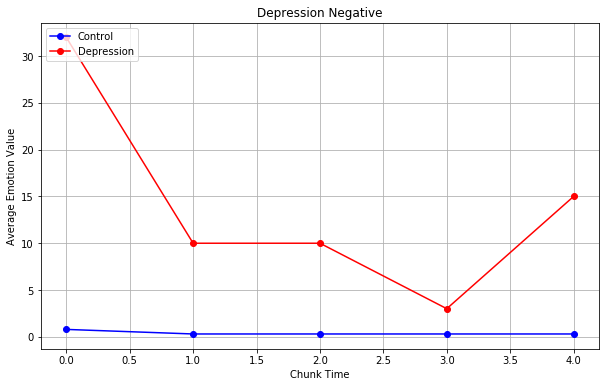

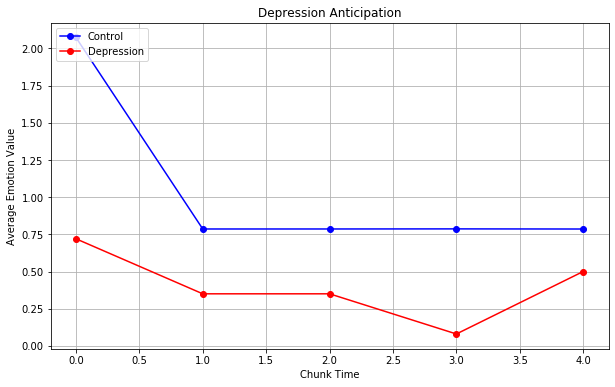

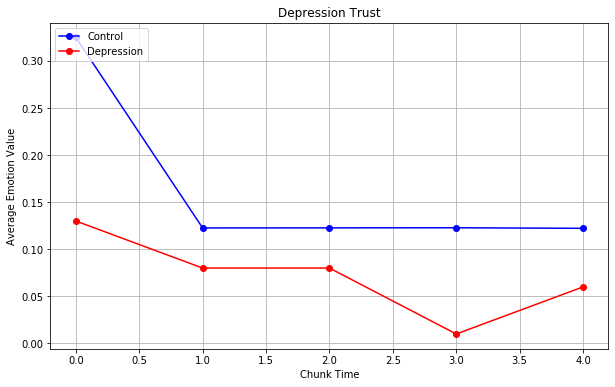

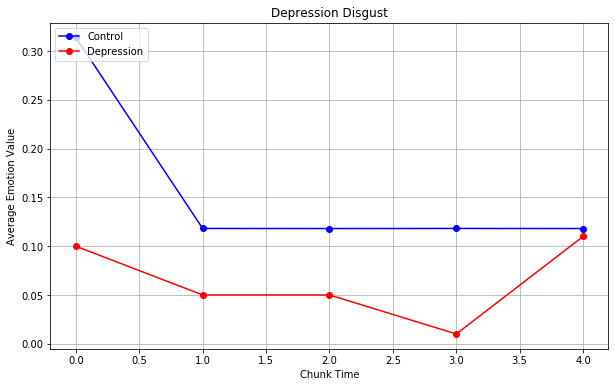

In [25]:
graph("Depression Anger",control_anger_group,depression_anger_group)
graph("Depression Negative",control_negative_group,depression_negative_group)
graph("Depression Anticipation",control_anti_group,depression_anti_group)
graph("Depression Trust",control_trust_group,depression_trust_group)
graph("Depression Disgust",control_disgust_group,depression_disgust_group)

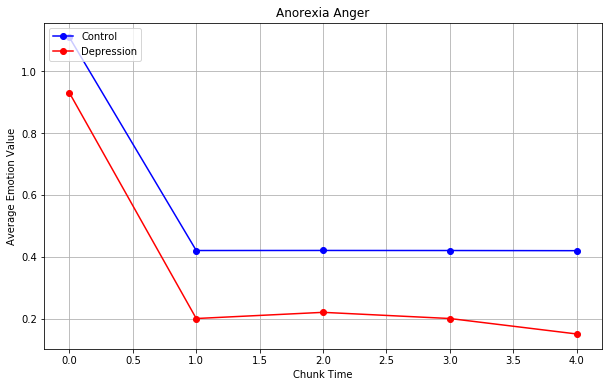

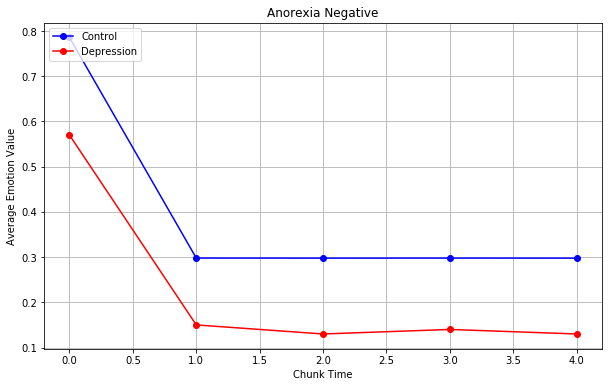

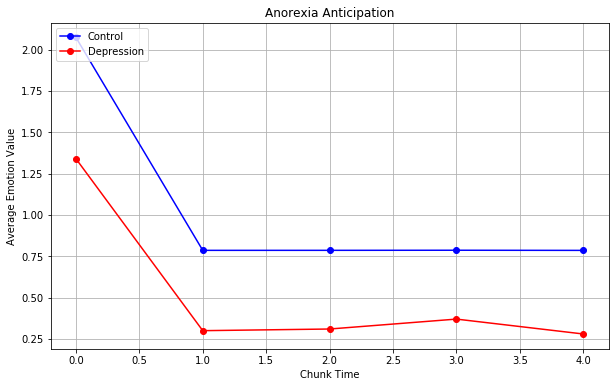

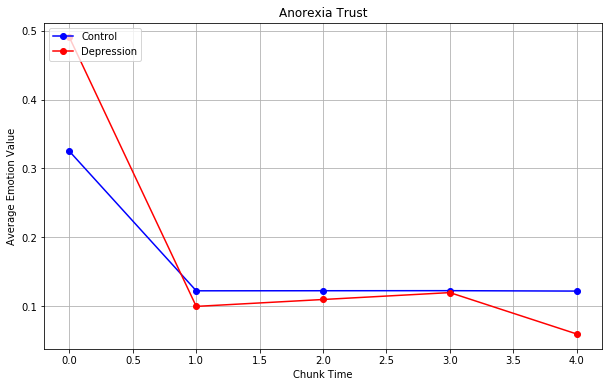

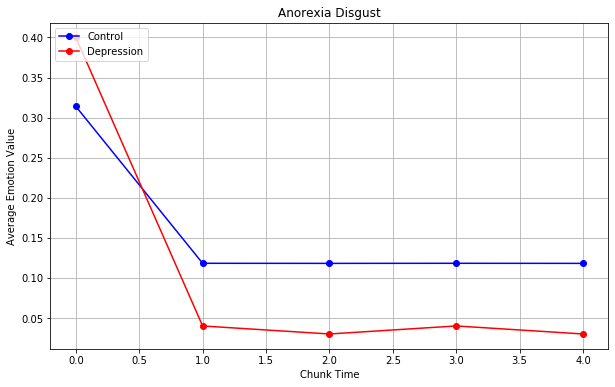

In [26]:
graph("Anorexia Anger",control_anger_group,ano_anger_group)
graph("Anorexia Negative",control_negative_group,ano_negative_group)
graph("Anorexia Anticipation",control_anti_group,ano_anti_group)
graph("Anorexia Trust",control_trust_group,ano_trust_group)
graph("Anorexia Disgust",control_disgust_group,ano_disgust_group)

In [41]:
print("Please enter your post here")
usr_input = input()
textData = usr_input.strip().lower()
testReview = tfidf_vectorizer.transform([textData]).toarray()
testReview = testReview.reshape(testReview.shape[0],testReview.shape[1],1,1)
predict = classifier.predict(testReview)
predict = np.argmax(predict)
result = "No Depression Detected"
if predict == 1:
    result = "Depression Detected"
tokens = textData.split(" ")
emotion = ''
for token in tokens:
    sub_emotion = getEmotion(token.strip())
    if sub_emotion is not None:
        emotion += sub_emotion+" "  
        if sub_emotion == "negative" or sub_emotion == 'anger':
            result = "Depression Detected"            
        
print("For given post : "+result)
print("Emotion Detected as : "+str(emotion))

Please enter your post here
morning is very pleasant today
For given post : No Depression Detected
Emotion Detected as : anticipation 
